In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Custom libraries/methods
from libs import split_data, evaluate_model

In [2]:
# Load dataset
df = pd.read_csv("data/preprocessed/main_ML_ready.csv")
df.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Store_Size,Year,Month,Day,Week,Store_Type_A,Store_Type_B,Store_Type_C
0,1,-0.963831,-1.72052,1.018422,0.078331,False,1,24924.50,0.238802,2010,2,5,5,True,False,False
1,1,-0.963831,-1.72052,1.018422,0.078331,False,2,50605.27,0.238802,2010,2,5,5,True,False,False
2,1,-0.963831,-1.72052,1.018422,0.078331,False,3,13740.12,0.238802,2010,2,5,5,True,False,False
3,1,-0.963831,-1.72052,1.018422,0.078331,False,4,39954.04,0.238802,2010,2,5,5,True,False,False
4,1,-0.963831,-1.72052,1.018422,0.078331,False,5,32229.38,0.238802,2010,2,5,5,True,False,False


### Split Data

In [3]:
# Split the data
X_train, X_test, y_train, y_test = split_data(df, target_column="Weekly_Sales")
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (336169, 15)
y_train shape:  (336169,)
X_test shape:  (84043, 15)
y_test shape:  (84043,)


# 1. XGBoost model

### 1.1 Train XGBoost model

In [4]:
# Initialize the XGBoost Regressor
# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(
    random_state=42,  # For reproducibility
    max_depth=None    # Default depth (unrestricted)
)

# Train the model
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [5]:
# Make predictions on the test set
y_pred = dt_model.predict(X_test)
evaluate_model(y_test, y_pred)

Mean Absolute Error (MAE): 1712.99
Root Mean Squared Error (RMSE): 4123.78
R² Score: 0.97


### 1.2 Hyperparameter Tuning

In [6]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [4, 6, 8, 10, None],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],   # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum samples required to be at a leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Consistent with XGBoost scoring
    cv=3,                               # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score (Negative MAE):", grid_search.best_score_)


Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Cross-Validation Score (Negative MAE): -1766.350121428666


### Evaluate the Tuned Model

In [7]:
# Retrieve the best model
best_dt_model = grid_search.best_estimator_

# Calculate evaluation metrics with the best model
y_pred = best_dt_model.predict(X_test)
evaluate_model(y_test, y_pred)

Mean Absolute Error (MAE): 1599.52
Root Mean Squared Error (RMSE): 3916.31
R² Score: 0.97


### Feature Importance Plot from

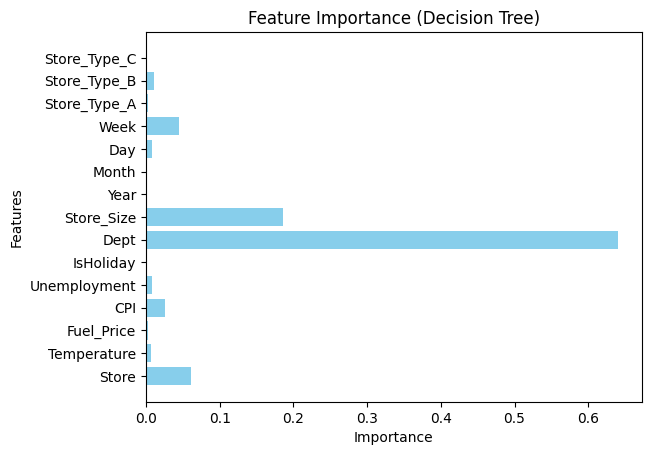

In [8]:
# Feature Importance
importances = best_dt_model.feature_importances_
features = X_train.columns

plt.barh(features, importances, color="skyblue")
plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()